# 🧩 implicitquotas: Quick Start Demo

This notebook demonstrates the core functionality of the `implicitquotas` package (to be published upon acceptance):

<ul>
  <li> Performing formal tests with asymptotic guarantees (static and panel version) from: </li> 
    <ul>
      <li> (panel) "Beyond the pipeline: assessing gender neutrality in board appointments in corporate Europe" 2025 (under submission) </li>
      <li> (static) "Testing the Presence of Implicit Hiring Quotas with Application to German Universities" 2024 L. Janys </li>
    </ul>
  <li> Performing bootstrap version of the testing procedure </li>
  <li> Visualizing results of the tests 
</ul>

The package contains the following functions:
- constructing shares from raw data on counts to construct benchmarks (`build_p_s`) 
- running the main test on the whole dataset from the article (`perform_analysis`) 
- running conditional test version of the main test (`zoom_in_analysis`)
- performing bootstrap if too few observations present (`panel_bootstrap`)
- visualizing the above (`plot_bootstrap`), (`plot_summary`), (`plot_heatmap`), (`plot_zoomed_results`)

In the following we perform a demonstration of package capabilities with the rela data used in the article. One can play with the functions locally with synth_data.csv which has the same structure.

In [1]:
# Install the package:
#%pip install -e .. 

#Import the package
import implicitquotas as iq 

# Import other useful packages for this demonstration
import pandas as pd
import numpy as np
from scipy.stats import binom
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from pathlib import Path
from scipy import stats

# Check the requirements.txt for all the required packages


## 1. Load a sample dataset

In [2]:
# ─── CONSTANTS ────────────────────────────────────────────────────────────────
SAVE_DIRECTORY = r"..\data"

# Where to find the CSV with the data, for example:
DATA_PATH = Path(r"..\data\data.csv")

In [3]:
# This is synthetic data generated for the purposes of demonstration
df = pd.read_csv(DATA_PATH) 
print(df.info()) 
print(df.head(3)) 
print(df.tail(3)) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23187375 entries, 0 to 23187374
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   country      object 
 1   year         int64  
 2   W            int64  
 3   M            int64  
 4   stocklisted  int64  
 5   group        object 
 6   id           int64  
 7   supply       float64
 8   total        float64
dtypes: float64(2), int64(5), object(2)
memory usage: 1.6+ GB
None
   country  year  W   M  stocklisted group     id  supply  total
0  AUSTRIA  2016  2  10            0     K  15717  29.517   12.0
1  AUSTRIA  2001  1   1            0     D  15723  29.334    2.0
2  AUSTRIA  2002  1   1            0     D  15723  30.776    2.0
           country  year  W  M  stocklisted group        id  supply  total
23187372  SLOVAKIA  2020  0  3            0     S  11701000  34.532    3.0
23187373  SLOVAKIA  2020  0  3            0     H  11701016  34.532    3.0
23187374  SLOVAKIA  2020  4  1            0     

In [4]:
df.describe()

,year,W,M,stocklisted,id,supply,total
count,2.318738e+07,2.318738e+07,2.318738e+07,2.318738e+07,2.318738e+07,2.268414e+07,2.318738e+07
mean,2.011552e+03,7.592137e-01,2.528479e+00,3.859428e-03,4.921304e+06,2.927406e+01,3.287693e+00
std,5.274934e+00,9.665242e-01,1.714484e+00,6.200430e-02,3.484569e+06,5.802912e+00,1.840989e+00
min,2.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.571700e+04,1.428300e+01,2.000000e+00
25%,2.008000e+03,0.000000e+00,2.000000e+00,0.000000e+00,2.156546e+06,2.476900e+01,2.000000e+00
50%,2.012000e+03,1.000000e+00,2.000000e+00,0.000000e+00,3.891170e+06,3.020200e+01,3.000000e+00
75%,2.016000e+03,1.000000e+00,3.000000e+00,0.000000e+00,8.390637e+06,3.293600e+01,4.000000e+00
max,2.020000e+03,4.300000e+01,5.000000e+01,1.000000e+00,1.170102e+07,5.220300e+01,5.000000e+01


- id ~ unit of observation
- year ~ time unit
- M ~ # of dominant group members
- W ~ # of minority group members
- total ~ sum of all members within a (year, id)
- group ~ subgroup for zommed analysis
- supply ~ external calculated probabilities for minorities

In [ ]:
from typing import Sequence, Tuple
# ─── HELPER FUNCTION FOR SUBSET CREATION ───────────────────────────────────────
# We apply tresholds on the data - to create takers
def filter_by_threshold_ever(
    base_df: pd.DataFrame,
    *,
    id_cols: Sequence[str],
    count_col: str,
    minority_col: str,
    threshold: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    1) Find all (id) pairs whose MAX(total) >= threshold at any year.
    2) Keep ALL rows (all years) for those firms.
    3) Within, compute sum of minority groups per (id).
       - If sum == 0, they never had any minority board seats in any year (in this subset).
       - Call those “never-takers”; drop them to form `subset_takers`.
    Returns: (subset_all, subset_takers)
    """
    # 1) which id‐group combos ever exceed threshold?
    firms_ever = (
        base_df
        .groupby(list(id_cols))[count_col]
        .max()
        .ge(threshold)
    )

    # 2) restrict to those combos (all years / rows)
    mask = base_df.set_index(list(id_cols)).index.isin(
        firms_ever[firms_ever].index
    )
    subset_all = base_df.loc[mask].copy()

    # 3) sum up female_col within each id‐group
    fem_sum = subset_all.groupby(list(id_cols))[minority_col]\
                        .transform("sum")
    subset_takers = subset_all.loc[fem_sum.gt(0)].copy()

    return subset_all, subset_takers

dfr, takers = filter_by_threshold_ever(
    df,
    id_cols    = ["id", "year"],
    count_col  = "total",
    minority_col = "W",
    threshold  = 2,
)

In [6]:
print(dfr.shape)
print(takers.shape)

(23187375, 9)
(11878188, 9)


## 2. Performing bootstrap

Lets perform bootstrap test on this real data to tets teh hypothesis for z=2

C:\Users\huber\Dropbox\2024_Papers\training\ImplicitQuotas\src\implicitquotas\bootstrap.py:116: UserWarning: Detected probability values > 1; converting by dividing by 100.
  warnings.warn("Detected probability values > 1; converting by dividing by 100.")


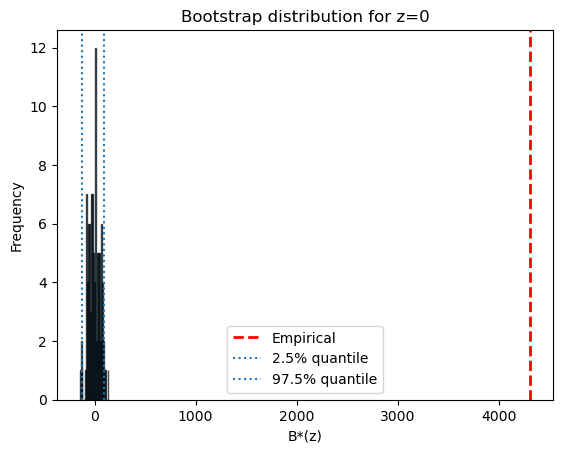

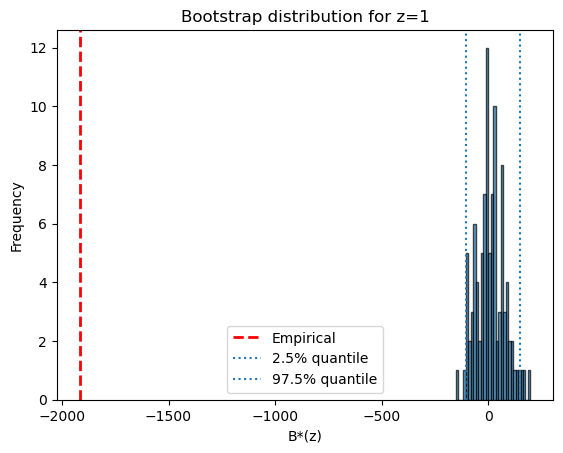

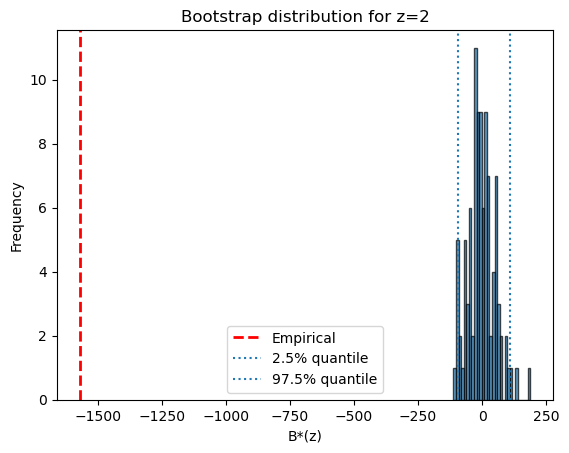

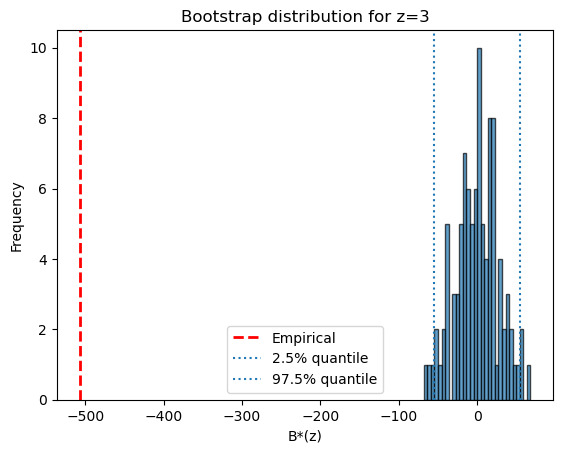

In [8]:
result = iq.analyze_bootstrap(
        df=dfr[(dfr.year==2019) & (~dfr.supply.isna()) & (dfr.country=="AUSTRIA")], 
        id_col='id',             # unit
        female_col='W',          # one group
        male_col='M',            # other group
        p_col='supply',          # externally calculated supply
        agg=6,                   # where to group the number of counts z. If agg=6, the test statistic is calculated for z=1,2,3,4,5,6+
        z=[0,1,2,3],             # a list of p-values and plots to be shown out of the z defined with agg above
        alpha=0.05,              # signifficance level for testing
        panel=False,             # cross-sectional, since no appointments/resignations
        year_col='year',         # ignored when panel=False
        appointments_col=None,   # ignored
        resignations_col=None,   # ignored
        B=100,
        init_with_observed=True,
        random_state=42,
        n_jobs=1
    )

In [30]:
print(f'Bootstrap p-value for z=2: {result["results"][2]["p_value"]:.4f}')
print(f'Reject null? {result["results"][2]["reject"]}')
    # Show plot
fig = result['figs']
plt.show() 

Bootstrap p-value for z=2: 0.0000
Reject null? True


The result is a dictionary

z = 0


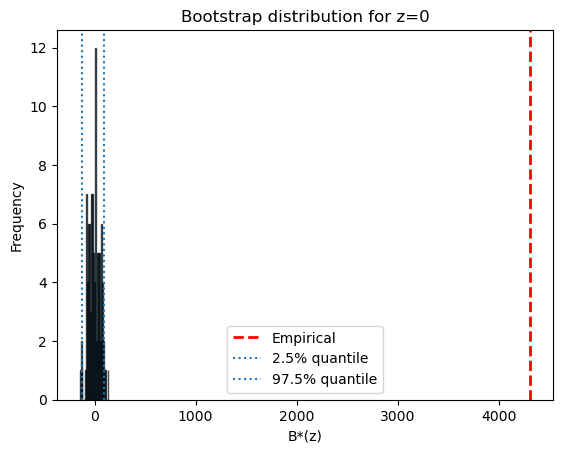

z = 1


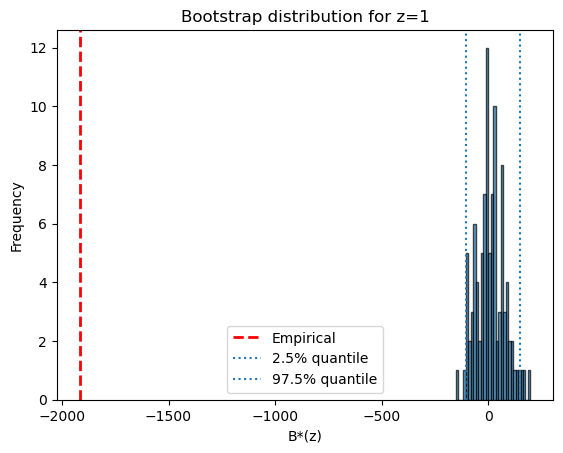

z = 2


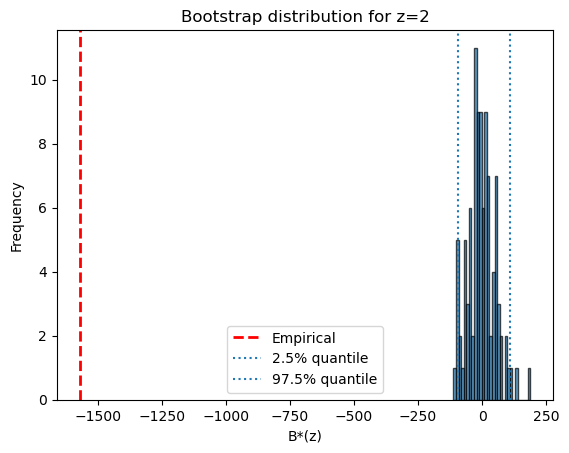

z = 3


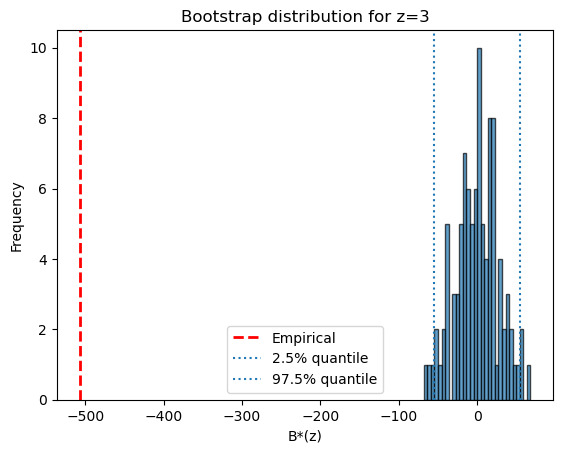

In [33]:
for z, fig in result["figs"].items():
    print(f"z = {z}")
    display(fig)   # in Jupyter

Lets now generate data that obeys neutrality and perform the same test

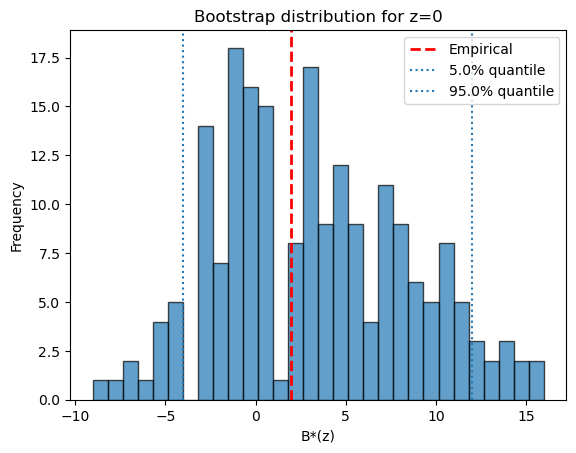

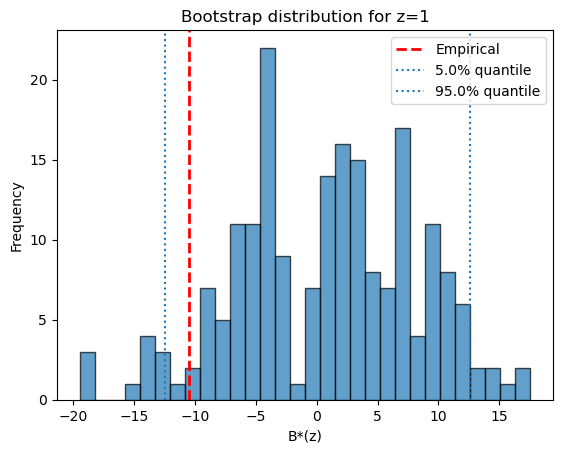

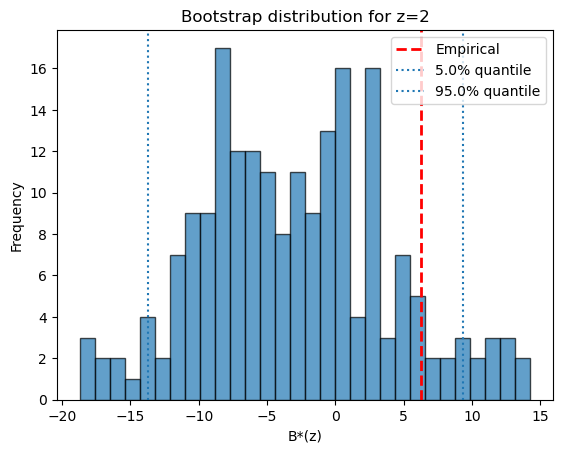

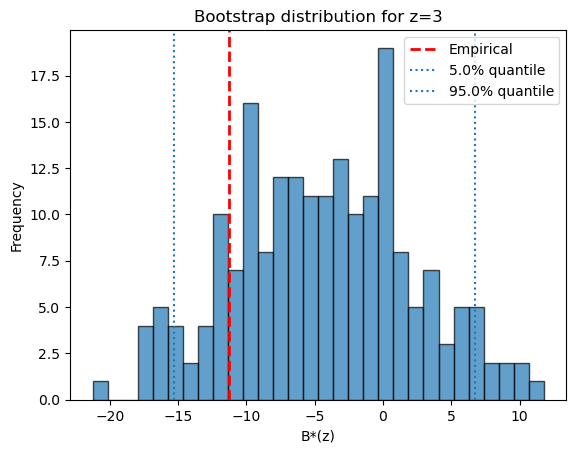

In [36]:
def simulate_panel_data(
        n_firms: int = 5,
        years: list = [2018, 2019, 2020],
        board_size: int = 6
    ) -> pd.DataFrame:
        """
        Create a simple panel DataFrame with constant board size,
        random probabilities, random hires/resignations.
        """
        rows = []
        rng = np.random.RandomState(0)
        for firm_id in range(1, n_firms + 1):
            # generate a base probability for each firm
            base_p = rng.uniform(0.2, 0.8)
            current_f = rng.binomial(board_size, base_p)
            current_m = board_size - current_f
            for year in years:
                # record observed counts
                prob = base_p + rng.normal(0, 0.05)
                prob = np.clip(prob, 0, 1)
                # simulate appointments and resignations small
                A = rng.randint(0, 3)
                R = rng.randint(0, 3)
                rows.append({
                    'id_bvd': f'F{firm_id}',
                    'year': year,
                    'W': current_f,
                    'M': current_m,
                    'supply': prob,
                    'appointments': A,
                    'resignations': R
                })
                # update composition for next year
                new_f = rng.binomial(A, prob)
                new_m = A - new_f
                # resignation removal weighted
                drop_f = rng.binomial(R, current_f / max(current_f+current_m,1)) if R>0 else 0
                drop_m = R - drop_f
                current_f = max(0, current_f + new_f - drop_f)
                current_m = max(0, current_m + new_m - drop_m)
            # reset composition for next firm
            current_f = rng.binomial(board_size, base_p)
            current_m = board_size - current_f
        df_test = pd.DataFrame(rows)
        return df_test

    # Generate synthetic panel data
df_test = simulate_panel_data(n_firms=100, years=[2020, 2021, 2022], board_size=5)

    # Run panel bootstrap on the test data
result_test = iq.analyze_bootstrap(
        df=df_test,
        id_col='id_bvd',
        female_col='W',
        male_col='M',
        p_col='supply',
        agg=4,
        z=[0,1,2,3],
        alpha=0.1,
        panel=True,
        year_col='year',
        appointments_col='appointments',
        resignations_col='resignations',
        B=200,
        init_with_observed=True,
        random_state=123,
        n_jobs=1
    )

z=0: Empirical=1.974, p=0.870, reject=False
z=1: Empirical=-10.448, p=0.140, reject=False
z=2: Empirical=6.277, p=0.170, reject=False
z=3: Empirical=-11.240, p=0.300, reject=False


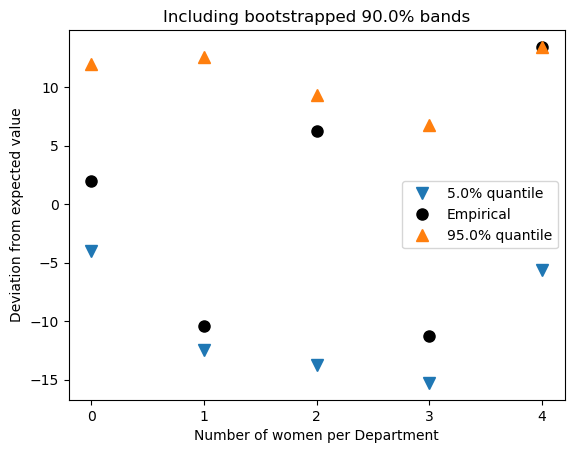

In [39]:
for z, stats in result_test["results"].items():
    emp_val = result_test["empirical"][str(z)]
    print(f"z={z}: Empirical={emp_val:.3f}, "
          f"p={stats['p_value']:.3f}, reject={stats['reject']}")

fig, ax = iq.plot_summary(result_test["boot_df"], result_test["empirical"], alpha=0.1)
plt.show()    

Lets see what happens if we skew the data artificially

z=0: Empirical=-27.026, p=0.000, reject=True
z=1: Empirical=28.552, p=0.190, reject=False
z=2: Empirical=50.277, p=0.000, reject=True
z=3: Empirical=24.760, p=0.020, reject=True


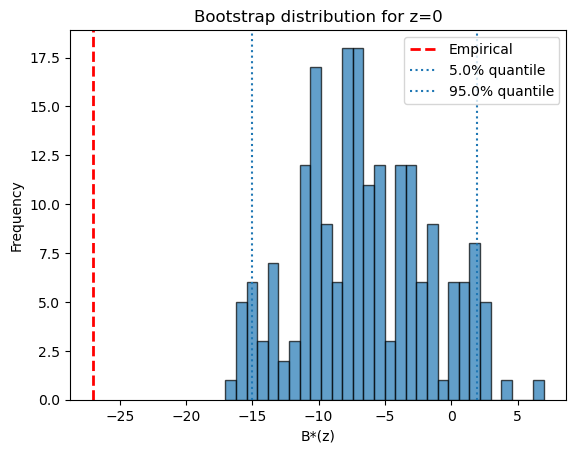

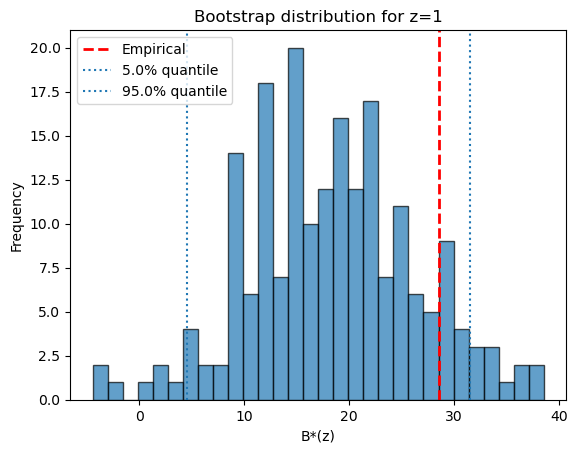

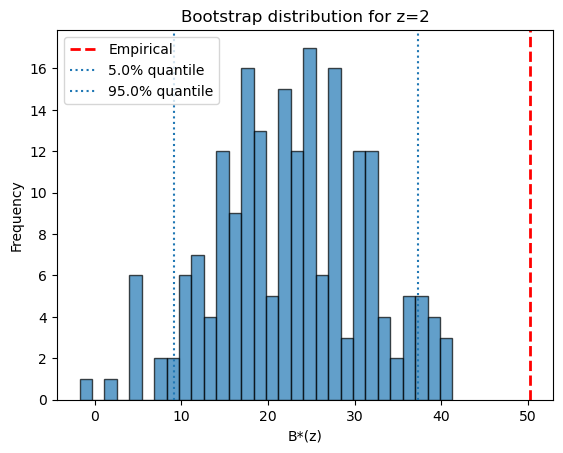

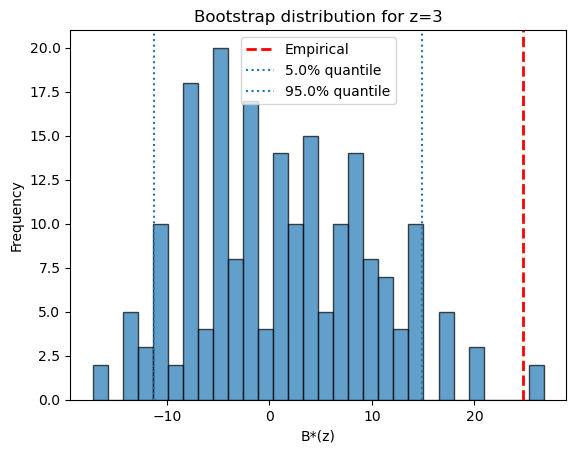

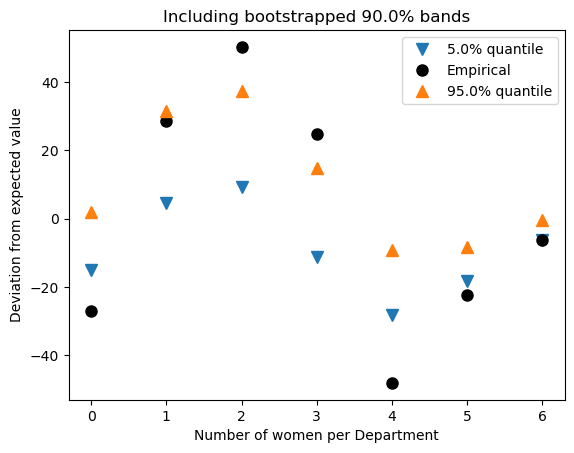

In [41]:
def simulate_targeted_panel(
    df: pd.DataFrame,
    female_col: str,
    male_col: str,
    p_col: str,
    id_col: str,
    year_col: str,
    z: int,
    delta: float
) -> pd.DataFrame:
    """
    Take a panel with columns [id_col, year_col, female_col, male_col,
    p_col, appointments, resignations] and override only W/M so that
    B(z) ≈ delta, while keeping appointments/resignations as in df.
    """
    # 1) copy and compute null‐model expectation
    df2 = df.copy().reset_index(drop=True)
    df2['n_d'] = df2[female_col] + df2[male_col]
    df2['p_z'] = binom.pmf(z, df2['n_d'], df2[p_col])
    expected = df2['p_z'].sum()

    # 2) compute how many rows to force Y=z
    target = int(round(expected + delta))
    target = max(0, min(len(df2), target))

    # 3) pick which rows become Y=z
    rng = np.random.RandomState(123)
    idx = np.arange(len(df2))
    rng.shuffle(idx)
    idx_z     = idx[:target]
    idx_other = idx[target:]

    # 4) build new Y_obs array
    max_n = int(df2['n_d'].max())
    Y_obs = np.empty(len(df2), dtype=int)
    Y_obs[idx_z] = z
    # for the rest, pick either z–1 or z+1 at random (clipped to [0,max_n])
    for i in idx_other:
        low, high = max(0, z-1), min(max_n, z+1)
        Y_obs[i] = rng.choice([low, high])

    # 5) overwrite W/M but **keep** appointments/resignations
    df2[female_col]   = Y_obs
    df2[male_col]     = df2['n_d'] - Y_obs
    # appointments/resignations are untouched

    # 6) drop helper columns
    return df2.drop(columns=['n_d','p_z'])

# --- Usage ---
# suppose `df_base` is your original panel with id_bvd, year, W, M, supply,...
df_targeted = simulate_targeted_panel(
    df=df_test,
    female_col='W',
    male_col='M',
    p_col='supply',
    id_col='id_bvd',
    year_col='year',
    z=2,
    delta=50     # force B(2) ≈ +50
) 

    # Run panel bootstrap on the test data
result_test = iq.analyze_bootstrap(
        df=df_targeted,
        id_col='id_bvd',
        female_col='W',
        male_col='M',
        p_col='supply',
        agg=6,
        z=[0,1,2,3],
        alpha=0.1,
        panel=True,
        year_col='year',
        appointments_col='appointments',
        resignations_col='resignations',
        B=200,
        init_with_observed=True,
        random_state=123,
        n_jobs=1
    ) 
for z, stats in result_test["results"].items():
    emp_val = result_test["empirical"][str(z)]
    print(f"z={z}: Empirical={emp_val:.3f}, "
          f"p={stats['p_value']:.3f}, reject={stats['reject']}")
    # Plot summary
fig, ax = iq.plot_summary(result_test['boot_df'], result_test['empirical'], alpha=0.1)
plt.show()

## 3. Formal tests

On the big synthetic dataset, lets perform the zoom in analysis - analysis per group with the formal test derived in the papers referenced

In [42]:
AGG = 6
out = iq.zoom_in_analysis(
     dfr,
     analysis_vars     = ['group'],
     group_vars_list   = [["year"]],
     female_col        = 'M',
     male_col          = 'W',
     id_col            = 'id',
     external_ps_col   = None,
     calculate_ps_before=True,
     candidate_pool    = None,
     agg               = AGG,
     panel             = True,
     n_jobs            = AGG + 1
 )

The result is in a particular format:

In [43]:
out

{('group',
  'K',
  ('year',),
  True,
  None):    z        T_n     numerator       p_value  H_d_sum        p_d_sum  \
 0  0   7.887330   3258.755040  3.108624e-15    25946   22687.244960   
 1  1  27.350080  31059.554169  0.000000e+00   240428  209368.445831   
 2  2  -8.180647 -10436.343790  2.220446e-16   567070  577506.343790   
 3  3 -29.144120 -31912.639851  0.000000e+00   403997  435909.639851   
 4  4 -10.146623  -6827.976453  0.000000e+00   164798  171625.976453   
 5  5   9.586183   4068.356145  0.000000e+00    74132   70063.643855   
 6  6  34.120892  10790.294740  0.000000e+00    88325   77534.705260   
 
    sigma_diag  sigma_d_sq_sum  
 0  148.209860      413.163260  
 1  397.155536     1135.629382  
 2  532.283946     1275.735727  
 3  478.437356     1094.994114  
 4  320.811919      672.930912  
 5  214.873507      424.397931  
 6  142.124194      316.237179  ,
 ('group',
  'D',
  ('year',),
  True,
  None):    z       T_n    numerator       p_value  H_d_sum        p_d_

### 3.1 Formal tests - example with real data

In [ ]:
# ---------------------------------------------------------------------
# 1) Data & column names you actually have
# ---------------------------------------------------------------------
female_col = "W"              # your “female count” column
male_col   = "M"
id_col     = "id"

# ---------------------------------------------------------------------
# 2) Configs identical to your notebook text
# ---------------------------------------------------------------------
all_group_vars_lists = [
    [["group", "year"]],                # <− only one scenario in your snippet
]

zoom_vars       = ["year", "group"]
dataset_configs = [                       # (nickname, df, agg)
    ("df_boot1", dfr, 3),
    ("df_boot5", takers, 5),
]

subgroup_defs = ["all"]                   # kept for API compat


# ---------------------------------------------------------------------
# 3) EXPERIMENT A  – explicit build_p_s + perform_analysis
# ---------------------------------------------------------------------
print("\n========= EXPERIMENT A  (manual build_p_s + perform_analysis) =========")
results_A = {}

for nick, df_in, agg_val in dataset_configs:
    for group_vars in all_group_vars_lists[0]:           # only one entry
        for calc_before in (True, False):
            for external_ps_col in (None,):              # your old loop tried "obs_value"/"ps"
                # ---- build p_s
                p_s = iq._build_p_s(
                    df                  = df_in,
                    group_vars          = group_vars,
                    female_col          = female_col,
                    male_col            = male_col,
                    external_ps_col     = external_ps_col,
                    calculate_ps_before = calc_before,
                    candidate_pool      = df_in if calc_before else None,
                )

                # ---- run analysis  (thread backend is hard-wired in helper)
                res = iq.perform_analysis(
                    df           = df_in,
                    p_s          = p_s,
                    group_vars   = group_vars,
                    female_col   = female_col,
                    male_col     = male_col,
                    id_col       = id_col,
                    agg          = agg_val,
                    panel        = True,
                    min_group_size = 10,
                    n_jobs       = agg_val + 1,          # any positive ⇒ threading
                )

                key = (nick, tuple(group_vars), calc_before, external_ps_col, agg_val)
                results_A[key] = res
                print(f"A  {key}:  shape = {res.shape}")


# # # ---------------------------------------------------------------------
# # # 5) OPTIONAL – adjust p-values, produce heat-maps
# # # ---------------------------------------------------------------------
# # # adjusted_B = adjust_p_values(results_B, method="HB")
# # # plot_zoomed_results(adjusted_B, save_dir1="./plots", save_dir2="new_asym")

In [ ]:
# ---------------------------------------------------------------------
# 4) EXPERIMENT B  – high-level zoom_in_analysis
# ---------------------------------------------------------------------
print("\n========= EXPERIMENT B  (zoom_in_analysis wrapper) =========")
results_B = {}

for group_vars_list in all_group_vars_lists:
    for zoom_var in zoom_vars:
        for nick, df_in, agg_val in dataset_configs:

            print(f"B  zoom={zoom_var}  data={nick}  agg={agg_val}")

            res_dict = iq.zoom_in_analysis(
                df                 = df_in,
                analysis_vars      = [zoom_var],          # <− exactly one “zoom” loop
                group_vars_list    = group_vars_list,
                female_col         = female_col,
                male_col           = male_col,
                id_col             = id_col,
                external_ps_col    = None,
                calculate_ps_before= True,
                candidate_pool     = None,
                agg                = agg_val,
                panel              = True,
                min_group_size     = 10,
                n_jobs             = agg_val + 1,         # threaded
            )

            # store every slice in the big result dict
            results_B.update(res_dict)


The results are in this format

In [ ]:
results_B

{('year',
  2016,
  'all',
  ('group', 'year'),
  True,
  None):    z        T_n    numerator   p_value  H_d_sum      p_d_sum  sigma_diag  \
 0  0 -32.122292 -1619.147006  0.000000        0  1619.147006   35.642221   
 1  1  15.871370  1048.681682  0.000000     4319  3270.318318   46.721230   
 2  2  23.075320  1519.452052  0.000000     4574  3054.547948   46.561211   
 3  3  -4.618641  -247.894097  0.000004     1552  1799.894097   37.952200   
 4  4 -10.613633  -391.177308  0.000000      384   775.177308   26.061211   
 5  5 -12.197181  -309.915324  0.000000      122   431.915324   17.966711   
 
    sigma_d_sq_sum  
 0       50.405712  
 1       66.073797  
 2       65.847496  
 3       53.672516  
 4       36.856118  
 5       25.408766  ,
 ('year',
  2012,
  'all',
  ('group', 'year'),
  True,
  None):    z        T_n    numerator       p_value  H_d_sum      p_d_sum  sigma_diag  \
 0  0 -38.207258 -2298.816577  0.000000e+00        0  2298.816577   42.544503   
 1  1  18.107797  142

They can be visualized the following way

In [ ]:
from implicitquotas.core import adjust_p_values
adjusted = adjust_p_values(results_B, method="HB")
iq.plot_zoomed_results(adjusted)